In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gdown
import zipfile
import os

plt.rcParams.update({
    "figure.figsize": (3.75, 3.0),
    "font.size": 12,
    "font.family": "serif",
    "axes.grid": True,
    "grid.alpha": 0.3,
    "savefig.dpi": 300
})

def create_index(data, col):
    """Sort-and-Split Indexing"""
    sorted_data = data[data[:, col].argsort()]
    boundaries = np.where(np.diff(sorted_data[:, col]) != 0)[0] + 1
    return np.split(sorted_data, boundaries)

def get_metrics(data, ub, mb, mu):
    """Vectorized RMSE and NLL"""
    # Prediction: mu + b_u + b_i
    preds = np.clip(mu + ub[data[:,0].astype(int)] + mb[data[:,1].astype(int)], 0.5, 5.0)
    residuals = data[:, 2] - preds
    rmse = np.sqrt(np.mean(residuals**2))
    nll = (np.sum(residuals**2) / 2.0) + (len(data)/2) * np.log(2 * np.pi)
    return rmse, nll

In [2]:
# 1. Load Small Dataset Zip
zip_path = 'ml-latest-small.zip'
if not os.path.exists(zip_path):
    gdown.download('https://files.grouplens.org/datasets/movielens/ml-latest-small.zip', zip_path, quiet=False)

with zipfile.ZipFile(zip_path, 'r') as z:
    with z.open('ml-latest-small/ratings.csv') as f:
        df = pd.read_csv(f)

# 2. Sequential Mapping
data = df[['userId', 'movieId', 'rating']].values
u_unique, u_map = np.unique(data[:, 0], return_inverse=True)
m_unique, m_map = np.unique(data[:, 1], return_inverse=True)
data[:, 0], data[:, 1] = u_map, m_map

# 3. Per-User Split 80% Train, 20% Test
user_index = create_index(data, 0)
np.random.seed(42)
train_l, test_l = [], []

for u_r in user_index:
    shuf = np.random.permutation(len(u_r))
    split = max(1, int(0.2 * len(u_r)))
    test_l.append(u_r[shuf[:split]])
    train_l.append(u_r[shuf[split:]])

train_data, test_data = np.vstack(train_l), np.vstack(test_l)
train_by_user = create_index(train_data, 0)
train_by_movie = create_index(train_data, 1)
global_mean = np.mean(train_data[:, 2])

print(f"Loaded {len(u_unique)} users and {len(m_unique)} movies.")

Downloading...
From: https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
To: /content/ml-latest-small.zip
100%|██████████| 978k/978k [00:00<00:00, 1.01MB/s]


Loaded 610 users and 9724 movies.


In [3]:
u_biases = np.zeros(len(u_unique))
m_biases = np.zeros(len(m_unique))
lambda_reg, iters = 10.0, 15
t_err, v_err = [], []
t_nll, v_nll = [], []

print(f"Running ALS (Global Mean: {global_mean:.4f})")
for i in range(iters):
    # Update User Biases
    for u_r in train_by_user:
        u = int(u_r[0,0])
        u_biases[u] = np.sum(u_r[:,2] - global_mean - m_biases[u_r[:,1].astype(int)]) / (len(u_r) + lambda_reg)

    # Update Movie Biases
    for m_r in train_by_movie:
        m = int(m_r[0,1])
        m_biases[m] = np.sum(m_r[:,2] - global_mean - u_biases[m_r[:,0].astype(int)]) / (len(m_r) + lambda_reg)

    rt, nt = get_metrics(train_data, u_biases, m_biases, global_mean)
    rv, nv = get_metrics(test_data, u_biases, m_biases, global_mean)

    t_err.append(rt); v_err.append(rv)
    t_nll.append(nt); v_nll.append(nv)

    print(f"Iter {i+1:2d} | Test RMSE: {rv:.4f} | Test NLL: {nv:.2f}")

Running ALS (Global Mean: 3.5021)
Iter  1 | Test RMSE: 0.8833 | Test NLL: 26102.91
Iter  2 | Test RMSE: 0.8759 | Test NLL: 25972.69
Iter  3 | Test RMSE: 0.8749 | Test NLL: 25955.77
Iter  4 | Test RMSE: 0.8746 | Test NLL: 25949.36
Iter  5 | Test RMSE: 0.8744 | Test NLL: 25946.12
Iter  6 | Test RMSE: 0.8743 | Test NLL: 25944.32
Iter  7 | Test RMSE: 0.8742 | Test NLL: 25943.27
Iter  8 | Test RMSE: 0.8742 | Test NLL: 25942.63
Iter  9 | Test RMSE: 0.8742 | Test NLL: 25942.24
Iter 10 | Test RMSE: 0.8741 | Test NLL: 25942.00
Iter 11 | Test RMSE: 0.8741 | Test NLL: 25941.84
Iter 12 | Test RMSE: 0.8741 | Test NLL: 25941.75
Iter 13 | Test RMSE: 0.8741 | Test NLL: 25941.69
Iter 14 | Test RMSE: 0.8741 | Test NLL: 25941.65
Iter 15 | Test RMSE: 0.8741 | Test NLL: 25941.62


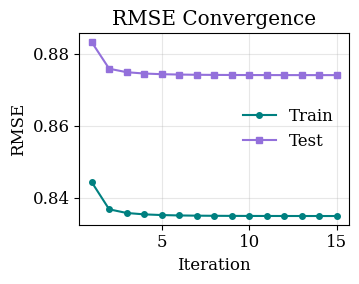

Final Test RMSE: 0.8741


In [4]:
# --- RMSE Plot ---
plt.figure()
plt.plot(range(1, iters+1), t_err, label='Train', color='teal', marker='o', markersize=4)
plt.plot(range(1, iters+1), v_err, label='Test', color='mediumpurple', marker='s', markersize=4)
plt.title('RMSE Convergence')
plt.xlabel('Iteration'); plt.ylabel('RMSE')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("prac2_rmse.pdf")
plt.show()
# --- Final Metrics ---
print(f"Final Test RMSE: {v_err[-1]:.4f}")